<a href="https://colab.research.google.com/github/skytecat/DL_study/blob/main/morse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()  # Загрузите kaggle.json вручную

!mkdir -p ~/.config/kaggle
!mv kaggle.json ~/.config/kaggle/
!chmod 600 ~/.config/kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c morse-decoder

morse-decoder.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile

with zipfile.ZipFile("morse-decoder.zip", 'r') as zip_ref:
    zip_ref.extractall("morse_data")  # Распаковка в папку morse_data

In [5]:
import pandas as pd

train_df = pd.read_csv("morse_data/train.csv")
test_df = pd.read_csv("morse_data/test.csv")

print(train_df.head())

       id     message
0  1.opus  03ЩУЫЛПИГХ
1  2.opus  ЪЛТ0ДС6А3Г
2  3.opus   5ЭКЫБЗХЯН
3  4.opus   ЖЫЦОИ68КФ
4  5.opus   32Ю7МЫ ЗЛ


In [6]:
from sklearn.model_selection import train_test_split

# Разделение (80% train, 20% validation)
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,  # Для воспроизводимости
)

print(f"Train: {len(train_data)} samples")
print(f"Validation: {len(val_data)} samples")
print(f'Test: {len(test_df)} samples')

Train: 24000 samples
Validation: 6000 samples
Test: 5000 samples


In [7]:
print(train_data.head(5))

               id     message
21753  21754.opus      РГШ28Ф
251      252.opus     ЦЧАЩ3ДМ
22941  22942.opus  2 М #ЮНЭОП
618      619.opus   ТЪ5Ю6Ы0БХ
17090  17091.opus  ФТЗСК ЙЭФТ


In [25]:
unique_chars = set(''.join(train_data['message']))
print(len(unique_chars))
print(unique_chars)

44
{'3', 'У', 'Ф', '4', 'Я', '5', 'Ы', 'Ш', 'А', '2', 'Д', 'Ъ', 'Ь', 'Э', '8', '0', ' ', 'М', '7', 'Ю', '6', 'Е', 'Ц', 'К', 'Р', 'Х', 'Т', 'П', 'С', '9', 'Ж', '1', 'Б', 'Г', 'Л', 'И', 'Ч', 'З', 'Й', 'Н', 'О', '#', 'Щ', 'В'}


In [95]:
MORSE_CODE_DICT = {
    # Русский алфавит
    'А': '.-', 'Б': '-...', 'В': '.--', 'Г': '--.', 'Д': '-..',
    'Е': '.', 'Ж': '...-', 'З': '--..', 'И': '..', 'Й': '.---',
    'К': '-.-', 'Л': '.-..', 'М': '--', 'Н': '-.', 'О': '---',
    'П': '.--.', 'Р': '.-.', 'С': '...', 'Т': '-', 'У': '..-',
    'Ф': '..-.', 'Х': '....', 'Ц': '-.-.', 'Ч': '---.', 'Ш': '----',
    'Щ': '--.-', 'Ъ': '--.--', 'Ы': '-.--', 'Ь': '-..-', 'Э': '..-..',
    'Ю': '..--', 'Я': '.-.-',

    # Цифры
    '1': '.----', '2': '..---', '3': '...--', '4': '....-', '5': '.....',
    '6': '-....', '7': '--...', '8': '---..', '9': '----.', '0': '-----',

    # Спецсимволы
    '#': '--.--', ' ': ' '
    # '.': '.-.-.-', ',': '--..--', '?': '..--..', "'": '.----.', '!': '-.-.--',
    # '/': '-..-.', '(': '-.--.', ')': '-.--.-', '&': '.-...', ':': '---...',
    # ';': '-.-.-.', '=': '-...-', '+': '.-.-.', '-': '-....-', '_': '..--.-',
    # '"': '.-..-.', '$': '...-..-', '@': '.--.-.', ' ': '/'
}

# Обратный словарь
RUSSIAN_TO_MORSE = MORSE_CODE_DICT
MORSE_TO_RUSSIAN = {v: k for k, v in MORSE_CODE_DICT.items()}
MORSE_TO_CODE = {'-': 0, '.': 1, ' ': 2}

def text_to_morse(text):
    """Перевод русского текста в азбуку Морзе"""
    morse = []
    for char in text.upper():
        if char in RUSSIAN_TO_MORSE:
            morse.append(RUSSIAN_TO_MORSE[char])
        else:
            morse.append('?')  # Для неизвестных символов
    return ' '.join(morse)

def morse_to_code(morse):
    """Перевод азбуки Морзе в код """
    code = []

    for m in morse:
      code.append(MORSE_TO_CODE[m])

    return code

def morse_to_text(morse):
    """Перевод азбуки Морзе в русский текст"""
    text = []
    for code in morse.split(' '):
        if code in MORSE_TO_RUSSIAN:
            text.append(MORSE_TO_RUSSIAN[code])
        else:
            text.append('?')  # Для неизвестных кодов
    return ''.join(text)

morse = text_to_morse('ПРИВЕТ')
print(morse)
print(morse_to_code(morse))

.--. .-. .. .-- . -
[1, 0, 0, 1, 2, 1, 0, 1, 2, 1, 1, 2, 1, 0, 0, 2, 1, 2, 0]


In [27]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

# Загрузка аудио
file_path = "morse_data/morse_dataset/morse_dataset/1.opus"
y, sr = librosa.load(file_path, sr=8000)  # Частота 8 кГц, как в задании

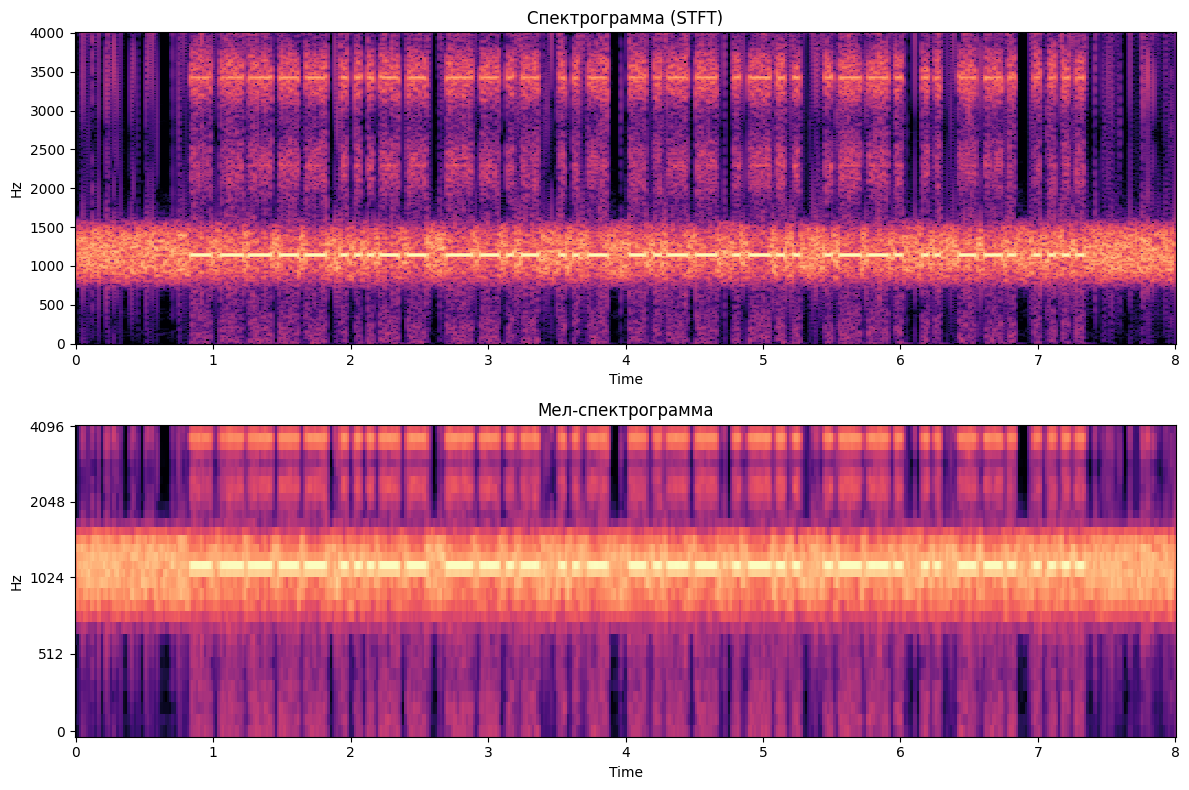

In [28]:
# Спектрограмма
D = librosa.stft(y, n_fft=512, hop_length=128)
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

# Мел-спектрограмма
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=32)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Отрисовка
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

librosa.display.specshow(S_db, sr=sr, hop_length=128, x_axis='time', y_axis='linear', ax=ax1)
ax1.set_title("Спектрограмма (STFT)")

librosa.display.specshow(mel_spec_db, sr=sr, hop_length=128, x_axis='time', y_axis='mel', ax=ax2)
ax2.set_title("Мел-спектрограмма")

plt.tight_layout()
plt.show()

In [10]:
y_clean = librosa.effects.preemphasis(y)  # Усиление высоких частот
# y_trimmed, _ = librosa.effects.trim(y_clean, top_db=1024)  # Обрезает тихие участки

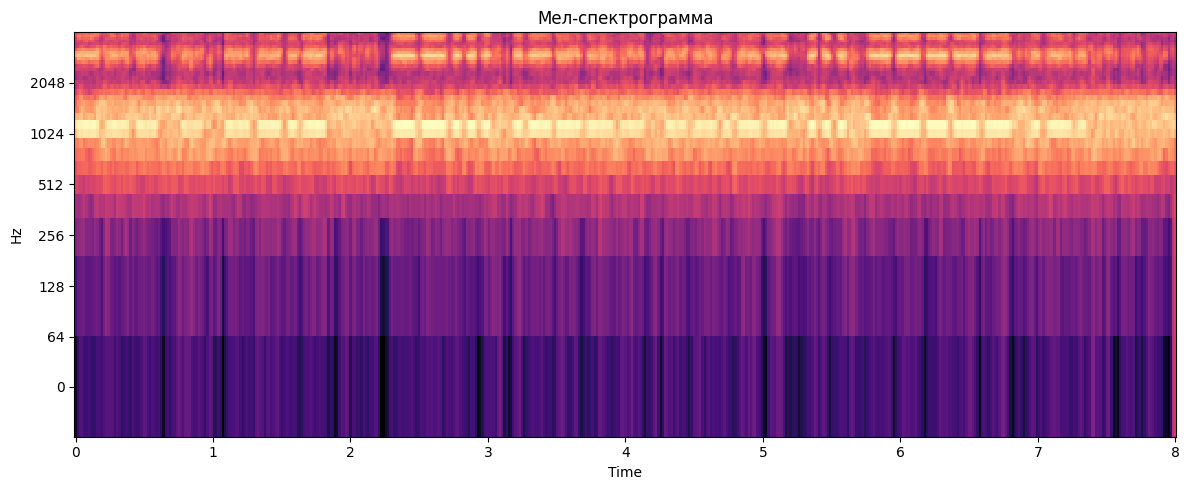

In [11]:
# Мел-спектрограмма
mel_spec = librosa.feature.melspectrogram(y=y_clean, sr=sr, n_fft=512, hop_length=128, n_mels=32)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / mel_spec_db.std() # нормализация

# Отрисовка
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))

# librosa.display.specshow(mel_spec_db, sr=sr, hop_length=128, x_axis='time', y_axis='mel', ax=ax1)
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=128, x_axis='time', y_axis='log', ax=ax1)

ax1.set_title("Мел-спектрограмма")

plt.tight_layout()
plt.show()

In [12]:
# Определяем диапазон частот для удаления (например, 1000-1500 Гц)
frequencies = librosa.mel_frequencies(n_mels=32, fmin=0, fmax=sr//2)  # Получаем центральные частоты мел-полос
mask = (frequencies < 1024) | (frequencies > 1200)


# Обнуляем ненужные частоты
mel_spec_db_filtered = mel_spec_db.copy()
mel_spec_db_filtered[mask, :] = -80  # -80 dB ~ "тишина"

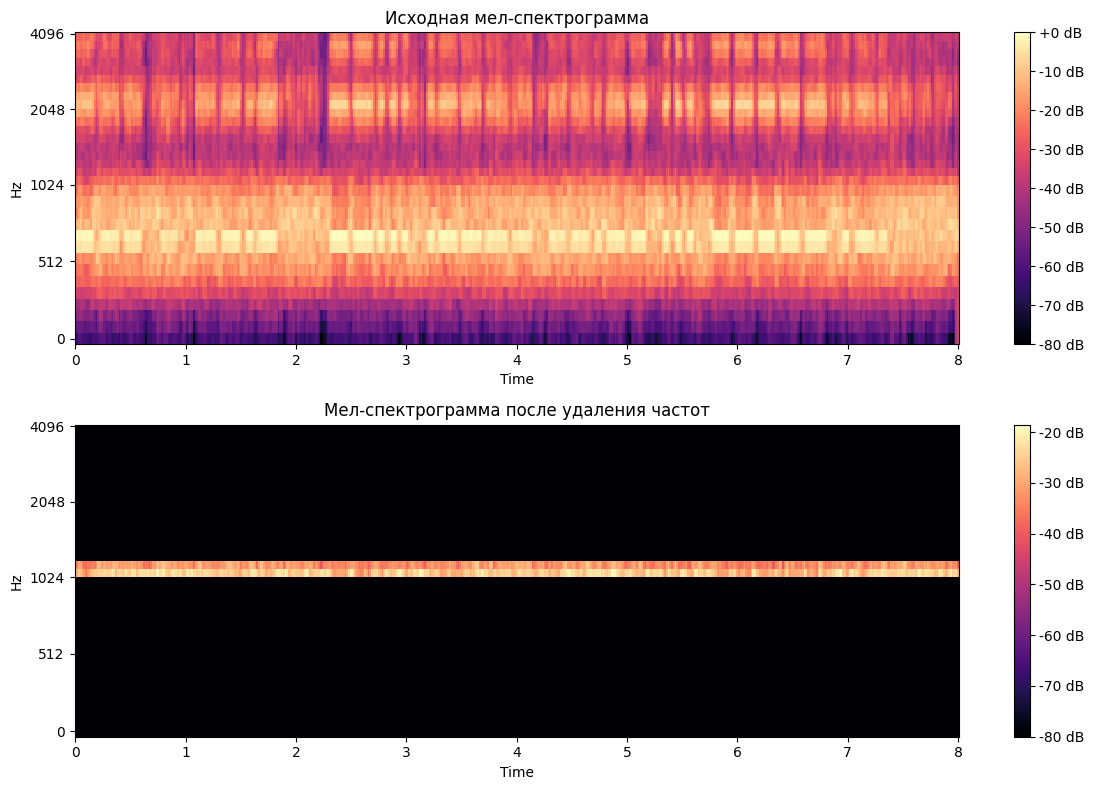

In [13]:
plt.figure(figsize=(12, 8))

# До фильтрации
plt.subplot(2, 1, 1)
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=128, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Исходная мел-спектрограмма')

# После фильтрации
plt.subplot(2, 1, 2)
librosa.display.specshow(mel_spec_db_filtered, sr=sr, hop_length=128, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Мел-спектрограмма после удаления частот')

plt.tight_layout()
plt.show()

In [160]:
from torch.utils.data import Dataset, DataLoader
import torch

class AudioDataset(Dataset):
    def __init__(self, audio_paths, messages, sr=8000):
        self.audio_paths = audio_paths
        self.messages = messages
        self.sr = sr

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        y, _ = librosa.load(self.audio_paths[idx], sr=self.sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=self.sr, n_fft=512, hop_length=128, n_mels=32)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        target = self.messages[idx]

        return (
            torch.tensor(mel_spec_db).unsqueeze(0),  # [n_mels, time]
            torch.tensor(target),        # [target_len]
            mel_spec_db.shape[1],       # input_length
            len(target)                 # target_length
        )
        # return torch.tensor(mel_spec_db).unsqueeze(0), self.messages[idx]

# Инициализация
audio_paths = train_data["id"].apply(lambda x: f"morse_data/morse_dataset/morse_dataset/{x}").tolist()
messages_text = train_data["message"].tolist()
morse_messages = list(text_to_morse(message) for message in messages_text)
code_messages = list(morse_to_code(message) for message in morse_messages)

# print(code_messages)
max_len = max(list(len(m) for m in code_messages)) # 64
padded_mes = [code + [-1] * (max_len - len(code)) for code in code_messages]

dataset = AudioDataset(audio_paths, padded_mes)
# # dataset = AudioDataset(audio_paths)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in dataloader:
  # print(batch)
  input, output, input_len, target_len = batch
  print(input.shape)
  print(output.shape)
  print(input_len.shape)
  print(target_len.shape)
  break
    # predictions = model(batch)


torch.Size([32, 1, 32, 501])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32])


# **Нужно поменять размеры input, output**

In [147]:
import torch.nn as nn
import torch.nn.functional as F

class MorseCRNN(nn.Module):
    def __init__(self, num_classes=3):  # 3 класса: точка, тире, пробел
        super().__init__()
        # CNN часть для извлечения признаков
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # RNN часть для обработки последовательностей
        self.rnn = nn.LSTM(
            input_size=32 * 8,  # Зависит от размеров после CNN
            hidden_size=64,
            bidirectional=True,
            batch_first=True
        )

        # Классификатор
        self.fc = nn.Linear(64 * 2, num_classes)  # x2 для bidirectional

    def forward(self, x):
        # x shape: [batch, 1, n_mels, time]
        x = self.cnn(x)

        # Подготовка для RNN
        batch, channels, freq, time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, freq]
        x = x.reshape(batch, time, -1)  # Объединяем каналы и частоты

        # RNN
        x, _ = self.rnn(x)

        # Классификация
        x = self.fc(x)
        return x  # [batch, time, num_classes]

In [ ]:
# def audio_to_mel(audio_path, sr=8000):
#     y, sr = librosa.load(audio_path, sr=sr)
#     mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=32, hop_length=128)
#     mel_db = librosa.power_to_db(mel, ref=np.max)
#     return torch.tensor(mel_db).unsqueeze(0)  # Добавляем размерность канала

In [156]:
model = MorseCRNN(num_classes=3)
criterion = nn.CTCLoss(blank=0)  # blank класс для CTC
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Пример обучения
# for epoch in range(10):
for epoch in range(1):
    for batch in dataloader:
        inputs, targets, input_lengths, target_lengths = batch
        # outputs = model(inputs)
        # inputs, targets = batch
        predict = model(inputs)

        # CTC требует особого формата
        # outputs = outputs.permute(1, 0, 2)  # [time, batch, classes]
        # outputs = predict.permute(1, 0, 2)
        loss = criterion(predict, targets, input_lengths, target_lengths)
        # # loss = criterion(outputs, targets)

        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()

RuntimeError: input_lengths must be of size batch_size